# Example getting capture

In [1]:
import evdm.ff as ff
import evdm
import numpy as np
import sympy
from IPython.display import display, Math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
My_op = ff.O(1,0)
My_op

For target nuclei we create instance of Nuclei class

In [3]:
H_nuc = ff.Nucleus(1,1)
H_nuc
C_nuc = ff.Nucleus(A=12,name='C') 
C_nuc
print(f'{H_nuc} with name {H_nuc.name}')
print(f'{C_nuc} with name {C_nuc.name}')

Nucleus(A = 1, Z = 1) with name H
Nucleus(A = 12, Z = 6) with name C


In [4]:
MyWimp = evdm.WimpModel(wimp_mass = 100,wimp_spin = 0.5)
MyWimp

Wimps(mass = 100, deltas = [0],spin = 0.5)

In [5]:
ScatterC = ff.ScatterModel(MyWimp(0,0),C_nuc,My_op,My_op,norm_dv = 0.1)
ScatterC

Scatter(WimpScatter(m = 100, delta = 0, j = 0.5) + Nucleus(A = 12, Z = 6), op = O_1)

In [6]:
SunModel = pd.read_csv("solar_model.dat",sep = '\t')

In [7]:
B = evdm.Body(SunModel['Rho'],Temp = SunModel['Temp']*evdm.K_to_GeV,velocity = 2e-3,dtype = 'float')
grid = evdm.GridEL(
    body = B,
    ptypes = 1,
    Ne = 20,
    Nl_func = lambda t_e: 20*t_e,
    RhoE = lambda te: 1-0.5*te, #optional
    RhoL = lambda te,tl: 1, #optional
    dtype = 'float')

Creating capture object

In [8]:
CaptureVec = evdm.Capture(grid)

Fill capture with some event

In [9]:
evdm.CaptureCalc(CaptureVec,ScatterC,[1,1],1e-3,1e-3,10000,0.39)

(10476.232421875, 15567.8212890625)

In [10]:
print(CaptureVec.count())#numer of captured particles per time

10476.240234375


In [11]:
CaptureVec.events

[( + W_m_0->0: 0.000000 [0.000000])]

In [29]:
def GetElementDense(m_body_model,m_body, element:evdm.ff.Nucleus):
    el_name_num = (element.name+str(element.A))
    if(el_name_num in m_body_model.columns):
        rho_e = m_body_model[el_name_num]
    elif(element.name in m_body_model.columns):
        rho_e = m_body_model[element.name]
    else:
        raise ValueError(f"no such element '{element}' in {m_body_model.columns}")
    
    return np.array(rho_e)*(m_body_model['Rho']/element.A)

In [26]:
(SunModel['Rho']*SunModel['Radius']**2*SunModel['Radius'][1]).sum()

0.33333206742199056

In [13]:
def TestCaptureMasses(m_grid,m_wimp_array,m_elements,m_table,m_body,m_operator): 
    X_plot_grid = [wimp.mass for wimp in m_wimp_array]
    def capt_element(element,m_wimp:evdm.WimpModel):
        Capt = evdm.Capture(m_grid)
        n_e = GetElementDense(m_table,m_body,element)
        scat_mod = ff.ScatterModel(m_wimp(0,0),element,m_operator,m_operator,2e-3)
        print(f'scat mod = {scat_mod}')
        print(f'factors = {scat_mod.coeffs}')
        try:
            return evdm.CaptureCalc(Capt,
                                    ff.ScatterModel(m_wimp(0,0),element,m_operator,m_operator,1e-3),
                                    n_e,0.73e-3,0.52e-3,100000)[0]
        except Exception as e:
            raise Exception(f"error at element {element}") from e
    Y_plots = [[capt_element(el,m_wimp) for m_wimp in m_wimp_array] for el in m_elements]
    return (X_plot_grid,Y_plots)

def TestCaptureMasses_Old(m_grid,m_wimp_array,m_elements,m_table,m_body,m_operator): 
    X_plot_grid = [wimp.mass for wimp in m_wimp_array]
    def capt_element(element,m_wimp:evdm.WimpModel):
        Capt = evdm.Capture(m_grid)
        n_e = GetElementDense(m_table,m_body,element)

        try:
            return evdm.CaptureCalc(Capt,
                                    ff.ScatterModel_SimpleFF(m_wimp(0,0),element),
                                    n_e,0.73e-3,0.52e-3,100000)[0]
        except Exception as e:
            raise Exception(f"error at element {element}") from e
    Y_plots = [[capt_element(el,m_wimp) for m_wimp in m_wimp_array] for el in m_elements]
    return (X_plot_grid,Y_plots)

In [31]:
test_element = [evdm.ff.Nucleus(1,name = "H"),
                evdm.ff.Nucleus(3,name = "He"),
                evdm.ff.Nucleus(4,name = "He"),
                evdm.ff.Nucleus(12,name = "C"),
                evdm.ff.Nucleus(14,name = "N"),
                evdm.ff.Nucleus(16,name = "O"),
                evdm.ff.Nucleus(56,name = "Fe")]
test_wimps = [evdm.WimpModel(10,0.5),
              evdm.WimpModel(20,0.5),
              evdm.WimpModel(40,0.5),
              evdm.WimpModel(80,0.5),
              evdm.WimpModel(100,0.5),
              evdm.WimpModel(120,0.5),
              evdm.WimpModel(160,0.5),
              evdm.WimpModel(200,0.5)
              ]

In [34]:
tests_capt = TestCaptureMasses(grid,test_wimps,test_element,SunModel,B,My_op)

scat mod = Scatter(WimpScatter(m = 10, delta = 0, j = 0.5) + Nucleus(A = 1, Z = 1), op = O_1)
factors = (7.297092311389389, False, [1.0])
scat mod = Scatter(WimpScatter(m = 20, delta = 0, j = 0.5) + Nucleus(A = 1, Z = 1), op = O_1)
factors = (7.297092311389389, False, [1.0])
scat mod = Scatter(WimpScatter(m = 40, delta = 0, j = 0.5) + Nucleus(A = 1, Z = 1), op = O_1)
factors = (7.297092311389389, False, [1.0])
scat mod = Scatter(WimpScatter(m = 80, delta = 0, j = 0.5) + Nucleus(A = 1, Z = 1), op = O_1)
factors = (7.297092311389389, False, [1.0])
scat mod = Scatter(WimpScatter(m = 100, delta = 0, j = 0.5) + Nucleus(A = 1, Z = 1), op = O_1)
factors = (7.297092311389389, False, [1.0])
scat mod = Scatter(WimpScatter(m = 120, delta = 0, j = 0.5) + Nucleus(A = 1, Z = 1), op = O_1)
factors = (7.297092311389389, False, [1.0])
scat mod = Scatter(WimpScatter(m = 160, delta = 0, j = 0.5) + Nucleus(A = 1, Z = 1), op = O_1)
factors = (7.297092311389389, False, [1.0])
scat mod = Scatter(WimpScatter(

0
1
2
3
4
5
6


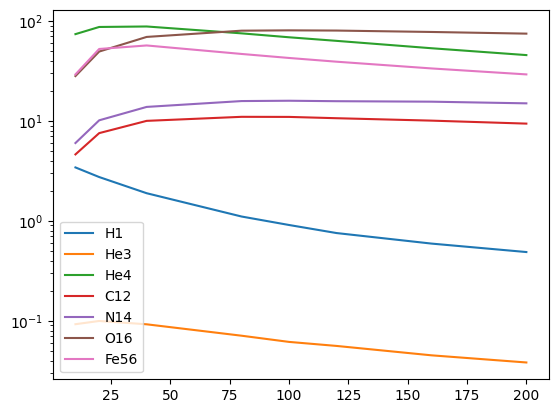

In [36]:
for i in range(len(tests_capt[1])):
    print(i)
    plt.plot(tests_capt[0],tests_capt[1][i]) 
plt.yscale('log')
plt.legend([w.name+str(w.A) for w in test_element])


In [32]:
print([te.name + str(te.A) for te in test_element]) 
tests_vals = [tc[0]*(3/4/3.145926) for tc in tests_capt[1]]
print(tests_vals)


['H1', 'He3', 'He4', 'C12', 'N14', 'O16', 'Fe56']
[0.9087325317903971, 68.58906747211141, 10.956825209886317, 15.89998066782164, 80.44613118159606, 42.588068617480396]
